In [13]:
# Importing necessary libraries for data handling
import pandas as pd
import numpy as np

# Importing visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Importing machine learning tools
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, ConfusionMatrixDisplay

# Importing deep learning tools from Keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Dropout, Conv1D, MaxPooling1D, Flatten, Dense, LSTM, Bidirectional, BatchNormalization
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam

# Configuring logging for debugging
import logging
logging.basicConfig(level=logging.WARNING, format='%(asctime)s - %(levelname)s - %(message)s')

# Setting display options for better visualization of data frames and figures
pd.set_option('display.max_colwidth', None)
plt.rcParams['figure.dpi'] = 500

# Load dataset
df = pd.read_feather("../Data/Data1.feather")

In [3]:
df.info()

df.sample(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21365 entries, 0 to 21364
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   text           21365 non-null  object
 1   company_names  21365 non-null  object
 2   sentiment      21365 non-null  int64 
 3   base_url       21365 non-null  object
dtypes: int64(1), object(3)
memory usage: 667.8+ KB


,text,company_names,sentiment,base_url
5428,trader sell valero energi vlo strength vlo,valero energi corpor,1,www.mareainformativa.com
17231,clorox clx receiv lower rate goldman sach analyst follow suit,clorox compani,-1,www.whatsonthorold.com
12717,get access premium paid group fraction price join us ric,hewlett packard enterpris compani,1,discord.gg
11660,isrg pre earn play move time last year day prior earn look result,intuit surgic,1,twitter.com
2762,pep vinix vitsx viiix pm sbux ed,consolid edison,0,seekingalpha.com


In [4]:
# Select relevant features and target variable
X = df[['text', 'company_names', 'base_url']]
Y = df['sentiment']

# Encode target labels to numerical values
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(Y)

# Split dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, encoded_labels, test_size=0.2, random_state=42)

In [5]:
# Concatenate textual features with a unique delimiter for clarity
delimiter = ' <EOF> '
X_train_combined = X_train['text'] + delimiter + X_train['company_names'] + delimiter + X_train['base_url']
X_test_combined = X_test['text'] + delimiter + X_test['company_names'] + delimiter + X_test['base_url']

# Initialize and fit tokenizer on training data
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train_combined)
X_train_seq = tokenizer.texts_to_sequences(X_train_combined)
X_test_seq = tokenizer.texts_to_sequences(X_test_combined)

In [6]:
max_sequence_length = 35

# Pad sequences to the same length for modeling
X_train_pad = pad_sequences(X_train_seq, maxlen=max_sequence_length, padding='pre')
X_test_pad = pad_sequences(X_test_seq, maxlen=max_sequence_length, padding='pre')

In [7]:
def build_sentiment_analysis_model(vocab_size, embedding_dim, num_filters, kernel_size, pool_size, dense_units, num_classes):
    """
    CNN-BiLSTM network model for sentiment analysis.
    """
    model = Sequential([
        Embedding(vocab_size, embedding_dim),
        Dropout(0.2),
        Conv1D(filters=num_filters, kernel_size=kernel_size, activation='relu', padding='same'),
        MaxPooling1D(pool_size=pool_size),
        BatchNormalization(),
        Bidirectional(LSTM(64, return_sequences=True)),
        Dropout(0.2),
        Flatten(),
        Dense(dense_units, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])
    return model

# Constants and K-fold initialisation
VOCAB_SIZE = 50000
EMBEDDING_DIM = 120
NUM_FILTERS = 128
KERNEL_SIZE = 3
POOL_SIZE = 3
DENSE_UNITS = 512
NUM_CLASSES = 3
K_FOLDS = 15

# Prepare callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('cnn_1_best_model.keras', save_best_only=True)

# K-fold cross-validation
fold_accuracies = []
fold_val_accuracies = []
fold_losses = []
fold_val_losses = []

kfold = KFold(n_splits=K_FOLDS, shuffle=True, random_state=42)
for train_indices, val_indices in kfold.split(X_train_pad):
    X_train_fold = X_train_pad[train_indices]
    y_train_fold = y_train[train_indices]
    X_val_fold = X_train_pad[val_indices]
    y_val_fold = y_train[val_indices]

    model = build_sentiment_analysis_model(VOCAB_SIZE, EMBEDDING_DIM, NUM_FILTERS, KERNEL_SIZE, POOL_SIZE, DENSE_UNITS, NUM_CLASSES)
    model.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    
    history = model.fit(X_train_fold, y_train_fold, epochs=10, batch_size=64, validation_data=(X_val_fold, y_val_fold), callbacks=[early_stopping, model_checkpoint])
    
    fold_accuracies.append(history.history['accuracy'])
    fold_val_accuracies.append(history.history['val_accuracy'])
    fold_losses.append(history.history['loss'])
    fold_val_losses.append(history.history['val_loss'])


Epoch 1/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 14s 46ms/step - accuracy: 0.6519 - loss: 1.0043 - val_accuracy: 0.7851 - val_loss: 0.6748
Epoch 2/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 13s 51ms/step - accuracy: 0.9588 - loss: 0.1288 - val_accuracy: 0.9079 - val_loss: 0.2346
Epoch 3/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 14s 55ms/step - accuracy: 0.9854 - loss: 0.0443 - val_accuracy: 0.9623 - val_loss: 0.1713
Epoch 4/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 13s 53ms/step - accuracy: 0.9931 - loss: 0.0213 - val_accuracy: 0.9632 - val_loss: 0.2194
Epoch 5/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.9939 - loss: 0.0163 - val_accuracy: 0.9658 - val_loss: 0.1980
Epoch 6/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 12s 48ms/step - accuracy: 0.9962 - loss: 0.0113 - val_accuracy: 0.9684 - val_loss: 0.1846
Epoch 1/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 13s 42ms/step - accuracy: 0.6740 - loss: 0.9107 - val_accuracy: 0.6728 - val_loss: 0.6391
Epoch 2/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 11s 42ms/step - accuracy: 0.9611 - loss: 0.1251 - 

In [8]:
# Find the maximum length of lists in each metric
max_length = max(max(len(acc) for acc in fold_accuracies), 
                 max(len(acc) for acc in fold_val_accuracies),
                 max(len(loss) for loss in fold_losses),
                 max(len(loss) for loss in fold_val_losses))

# Function to pad lists
def pad_metric_lists(metric_list, max_length):
    return [metric + [metric[-1]] * (max_length - len(metric)) for metric in metric_list]

# Pad all metric lists
padded_accuracies = pad_metric_lists(fold_accuracies, max_length)
padded_val_accuracies = pad_metric_lists(fold_val_accuracies, max_length)
padded_losses = pad_metric_lists(fold_losses, max_length)
padded_val_losses = pad_metric_lists(fold_val_losses, max_length)

# Calculate the mean across all folds
mean_accuracy = np.mean(padded_accuracies, axis=0)
mean_val_accuracy = np.mean(padded_val_accuracies, axis=0)
mean_loss = np.mean(padded_losses, axis=0)
mean_val_loss = np.mean(padded_val_losses, axis=0)

# Now you can safely print and plot these means
print(f"Mean Training Accuracy: {mean_accuracy[-1]:.6f}")
print(f"Mean Validation Accuracy: {mean_val_accuracy[-1]:.6f}")
print(f"\nMean Training Loss: {mean_loss[-1]:.6f}")
print(f"Mean Validation Loss: {mean_val_loss[-1]:.6f}")

Mean Training Accuracy: 0.987776
Mean Validation Accuracy: 0.959103

Mean Training Loss: 0.039377
Mean Validation Loss: 0.191473



Epoch 1:
  Training Accuracy: 0.794093
  Validation Accuracy: 0.651644
  Training Loss: 0.601523
  Validation Loss: 0.729247

Epoch 2:
  Training Accuracy: 0.962836
  Validation Accuracy: 0.917563
  Training Loss: 0.121148
  Validation Loss: 0.233350

Epoch 3:
  Training Accuracy: 0.986401
  Validation Accuracy: 0.958284
  Training Loss: 0.043520
  Validation Loss: 0.192086

Epoch 4:
  Training Accuracy: 0.987325
  Validation Accuracy: 0.958460
  Training Loss: 0.041048
  Validation Loss: 0.195215

Epoch 5:
  Training Accuracy: 0.987668
  Validation Accuracy: 0.959279
  Training Loss: 0.039805
  Validation Loss: 0.192566

Epoch 6:
  Training Accuracy: 0.987726
  Validation Accuracy: 0.959103
  Training Loss: 0.039447
  Validation Loss: 0.192336

Epoch 7:
  Training Accuracy: 0.987697
  Validation Accuracy: 0.958986
  Training Loss: 0.039584
  Validation Loss: 0.193098

Epoch 8:
  Training Accuracy: 0.987764
  Validation Accuracy: 0.959337
  Training Loss: 0.039321
  Validation Loss: 0

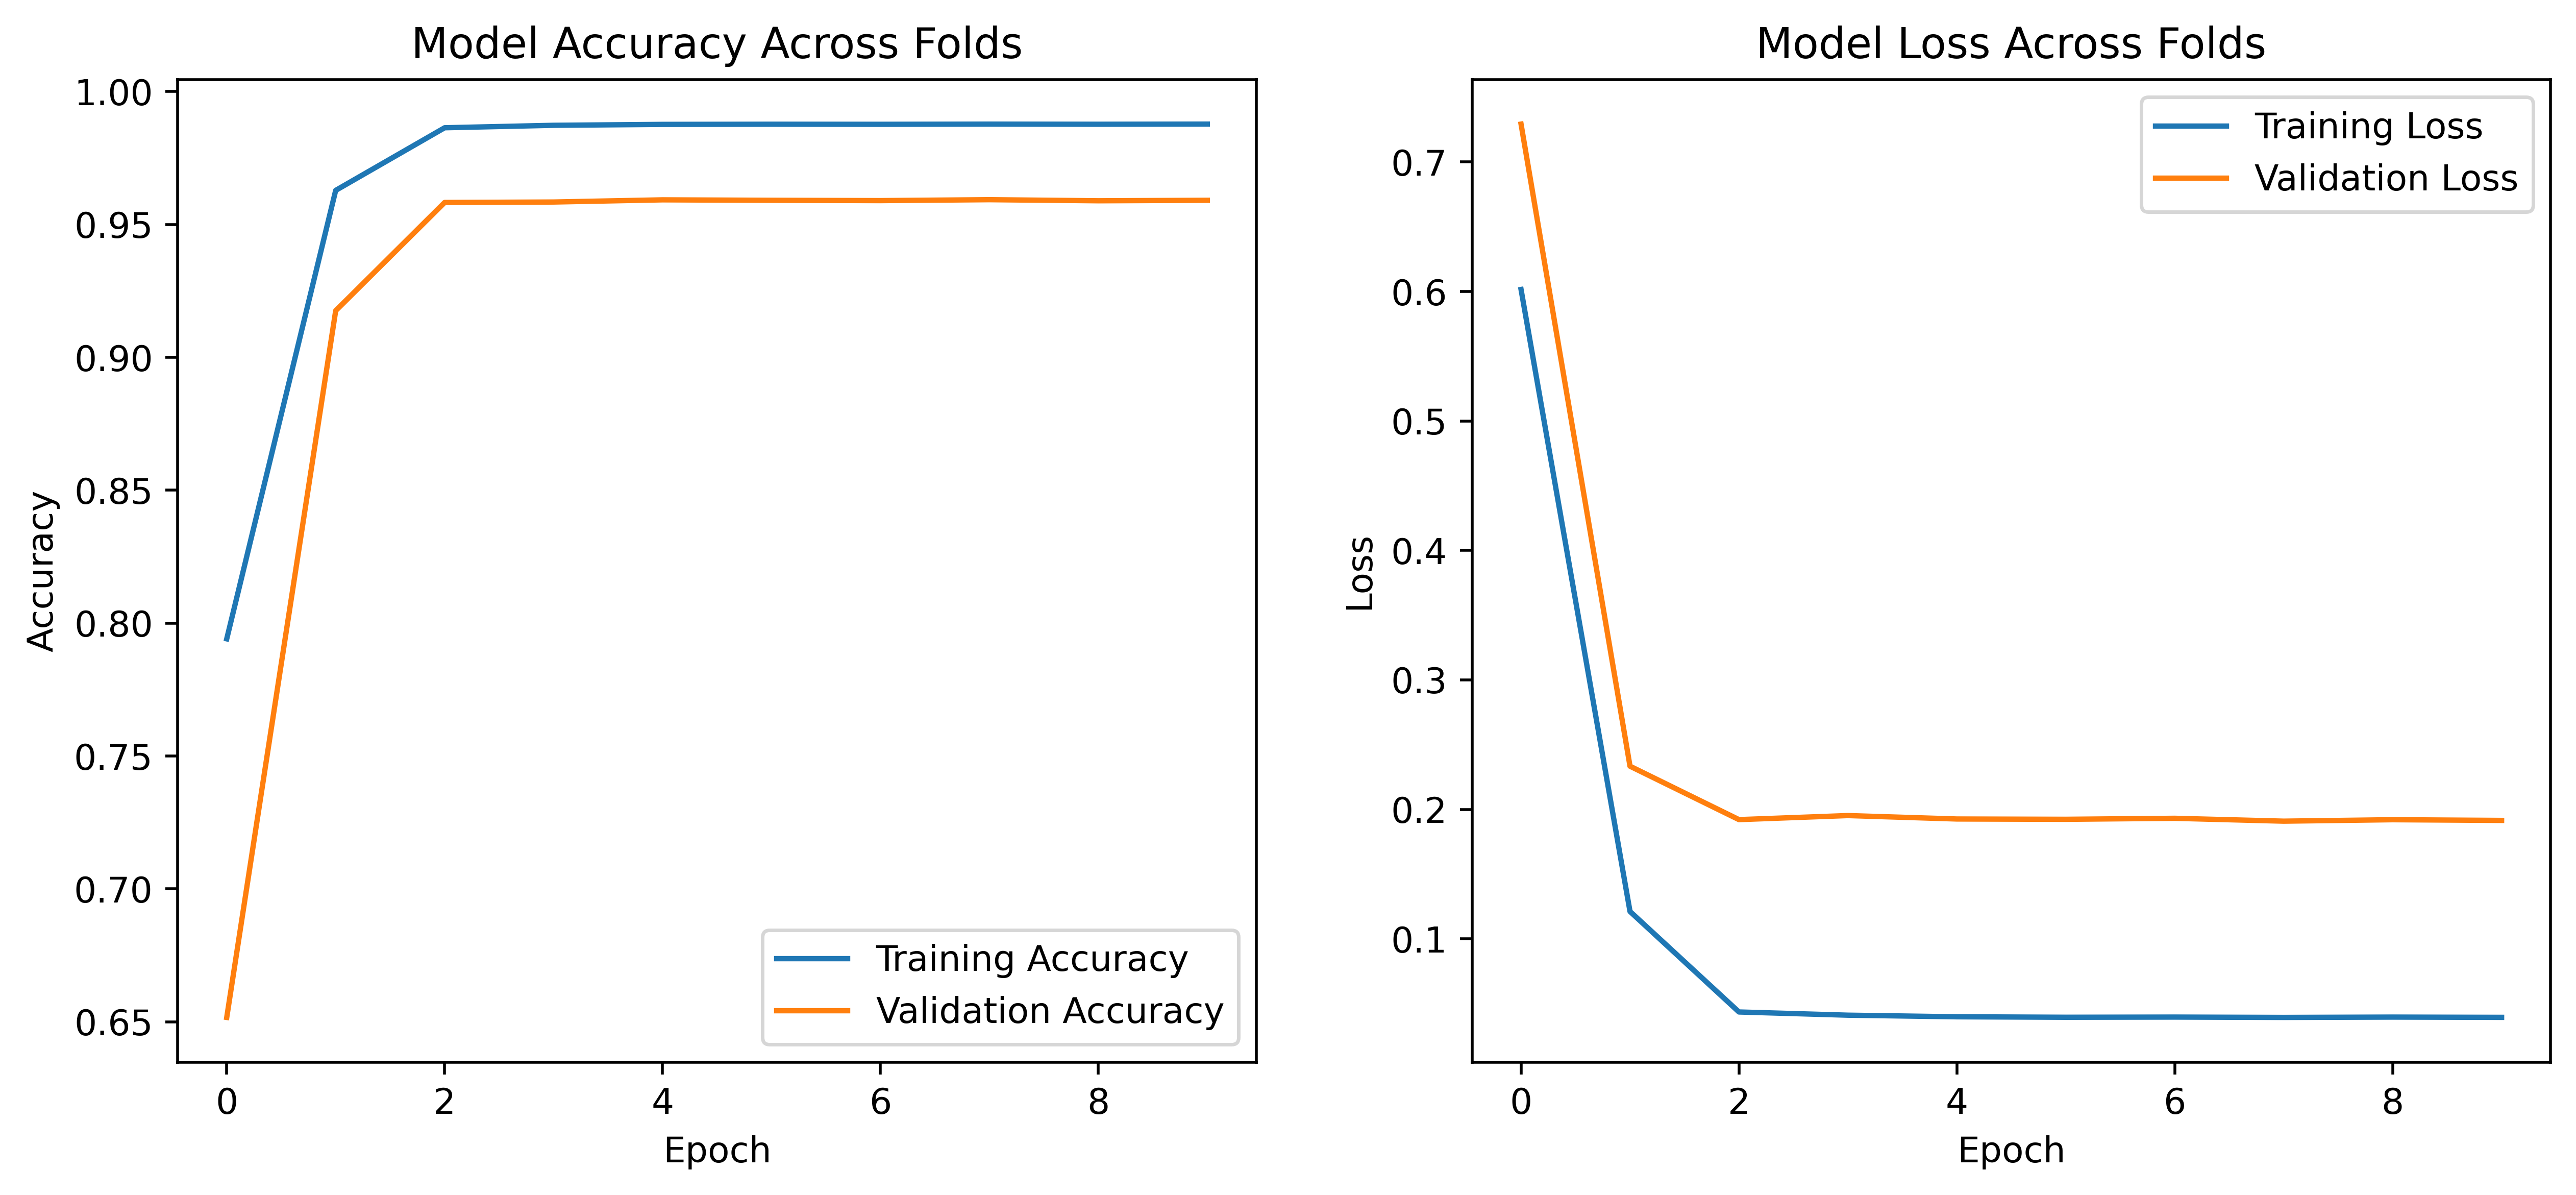

In [9]:
# Print epoch-wise training and validation metrics
for epoch in range(max_length):
    print(f"\nEpoch {epoch + 1}:")
    print(f"  Training Accuracy: {mean_accuracy[epoch]:.6f}")
    print(f"  Validation Accuracy: {mean_val_accuracy[epoch]:.6f}")
    print(f"  Training Loss: {mean_loss[epoch]:.6f}")
    print(f"  Validation Loss: {mean_val_loss[epoch]:.6f}")

# Plotting model accuracy and loss
plt.figure(figsize=(12, 5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(mean_accuracy, label='Training Accuracy')
plt.plot(mean_val_accuracy, label='Validation Accuracy')
plt.title('Model Accuracy Across Folds')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(mean_loss, label='Training Loss')
plt.plot(mean_val_loss, label='Validation Loss')
plt.title('Model Loss Across Folds')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()

plt.show()

In [10]:
# Assuming 'cnn_1_best_model.keras' is your best model saved during training
model.load_weights('cnn_1_best_model.keras')

# Convert the test set using the tokenizer and pad_sequences, just like you did for the training set
X_test_combined = X_test['text'] + delimiter + X_test['company_names'] + delimiter + X_test['base_url']
X_test_seq = tokenizer.texts_to_sequences(X_test_combined)
X_test_pad = pad_sequences(X_test_seq, maxlen=max_sequence_length, padding='pre')

# Evaluating the model on the test set
y_pred_test = model.predict(X_test_pad)
y_pred_classes_test = np.argmax(y_pred_test, axis=1)

134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step



Test Accuracy: 0.9693423824011234

Test Classification Report:
               precision    recall  f1-score   support

          -1       0.92      0.90      0.91       389
           0       0.98      0.98      0.98      2584
           1       0.97      0.97      0.97      1300

    accuracy                           0.97      4273
   macro avg       0.95      0.95      0.95      4273
weighted avg       0.97      0.97      0.97      4273


Test Confusion Matrix: 
 [[ 351   25   13]
 [  29 2526   29]
 [   3   32 1265]]


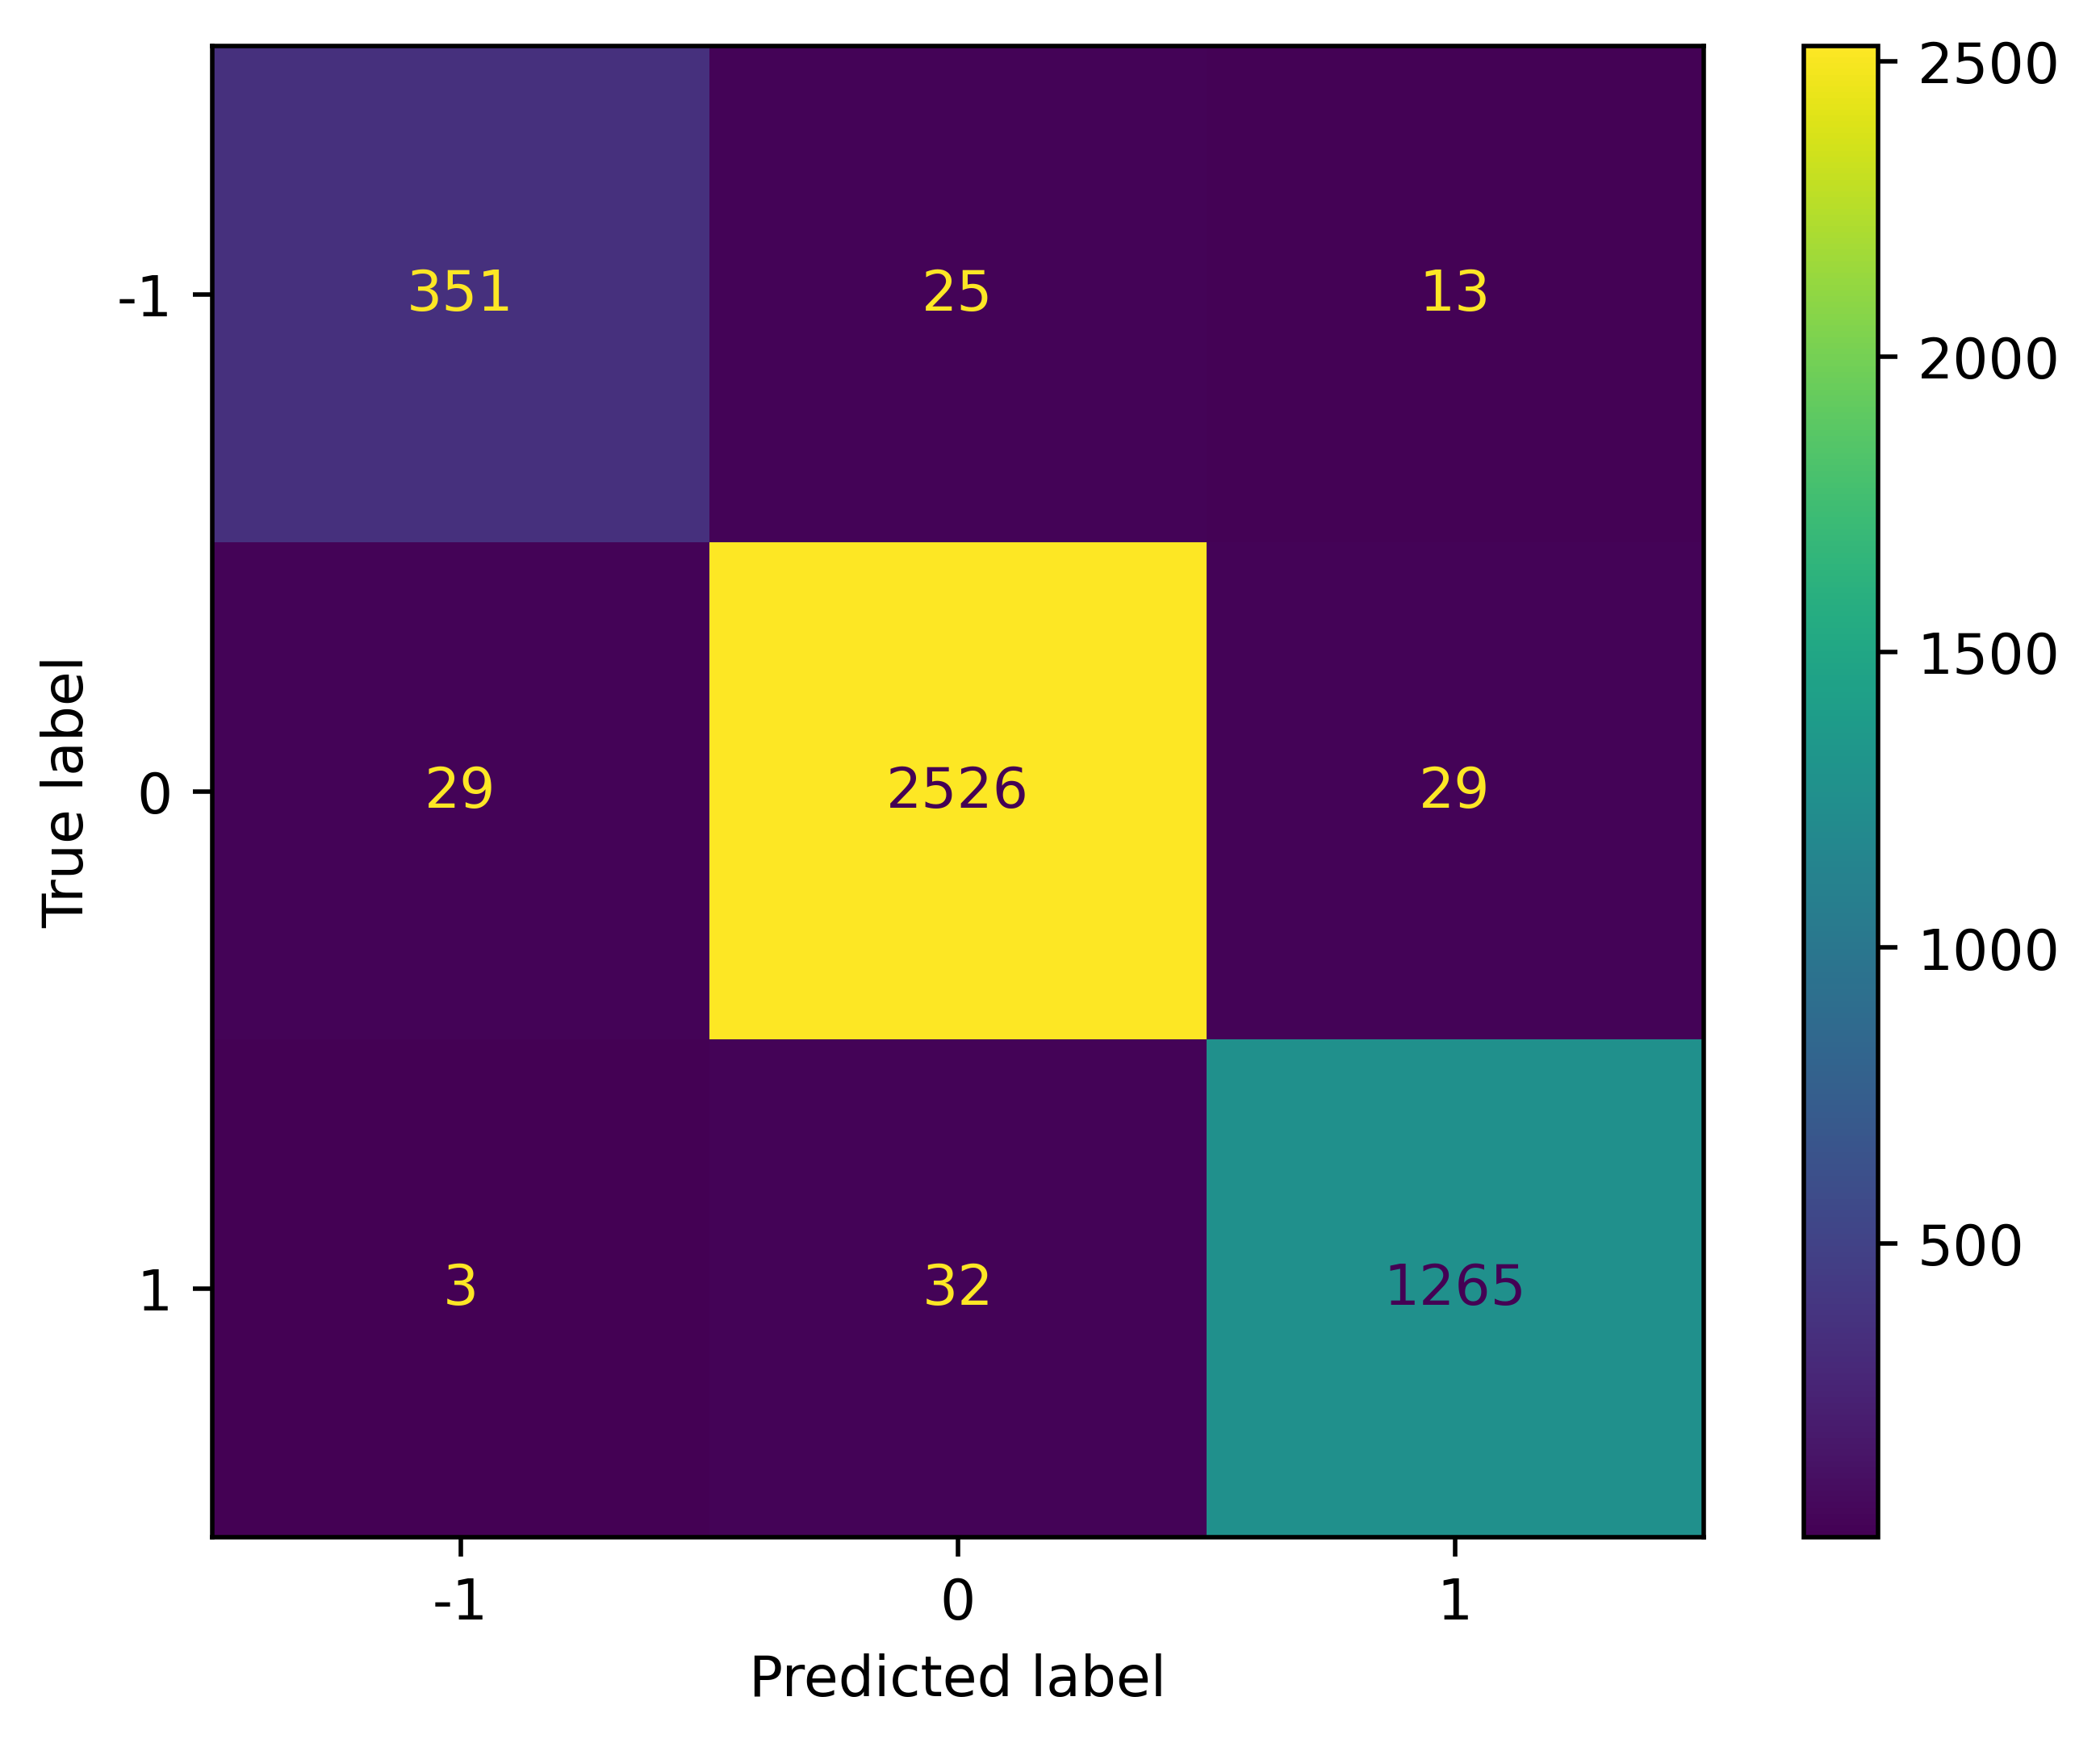

In [16]:
# Convert numeric labels to strings
target_names = [str(cls) for cls in label_encoder.classes_]

# Calculate accuracy
test_accuracy = accuracy_score(y_test, y_pred_classes_test)
print("\nTest Accuracy:", test_accuracy)

# Generate and print classification report
print("\nTest Classification Report:\n", classification_report(y_test, y_pred_classes_test, target_names=target_names))

# Compute and plot the confusion matrix
test_cm = confusion_matrix(y_test, y_pred_classes_test)

print("\nTest Confusion Matrix: \n", test_cm)

display = ConfusionMatrixDisplay(test_cm, display_labels=target_names)
display.plot()